In [ ]:
import numpy as np
import pickle
from scipy.stats import zscore
import pandas as pd
import torch

data = pickle.load(open('data/dataset.pickle', 'rb'))
print(data['info'])



In [ ]:
# one hot encoder
def one_hot_encode(arr, xtiles=4):
    df = pd.DataFrame(arr.flatten())
    ranked = df.rank(method='first').to_numpy().flatten()
    quartiles = pd.qcut(ranked, q=xtiles, labels=False)
    one_hot_quartiles = np.eye(xtiles)[quartiles]
    return one_hot_quartiles

one_hot_encode(data['run_speed'])
one_hot_encode(data['pupil_area'])


In [ ]:
import pickle
pca_graph = pickle.load(open('data/pca.pickle', 'rb'))
reduced_X = pca_graph.transform(data['responses'].T)


In [ ]:
# data prep
x = zscore(data['responses']).T         # (time x neurons)
#x = reduced_X                          # pca gave worse and wasn't faster
y = one_hot_encode(data['pupil_area'], xtiles=4)   # (time x 4)

tensor_x = torch.Tensor(x) # transform to torch tensor
tensor_y = torch.Tensor(y)

ds = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
train_set, test_set = torch.utils.data.random_split(ds, [6000, 1018])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
# Make the NN
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features_conv = torch.nn.Sequential(
            torch.nn.Linear(11983, 100),
            torch.nn.GELU(),
            torch.nn.Linear(100, 4),
        )        
        self.out1 = torch.nn.Softmax(dim=-1)
        
        
    def forward(self, x):
        x = torch.reshape(x, (1, 11983))
        x = self.features_conv(x)  
        x = self.out1(x)
        return x
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0003)

In [ ]:
import wandb
wandb.login()
wandb.init(project="neuro120-project")

In [ ]:


def test_error(net, test_loader):
    correct = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            
            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs.data)
            true = torch.argmax(labels.data)
            
            if predicted == true:
                correct += 1

            # print(predicted, true, (predicted == true).sum().item())
            # correct += (predicted == true).sum().item()

    return  correct / 1018


def train(net, train_loader, optimizer, criterion, epoch_test=True, test_loader=None):
    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data

            optimizer.zero_grad()      
            outputs = net(inputs)
        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
           

            if i % 300 == 0:
                print(f'epoch: {epoch + 1} loss: {running_loss / 10000:.3f}')
                
                if epoch_test:
                    acc = test_error(net, test_loader)
                    
                    #wandb.log({'accuracy': acc, 'loss': running_loss})

train(net, train_loader, optimizer, criterion, epoch_test=True, test_loader=test_loader)

print('Finished Training')

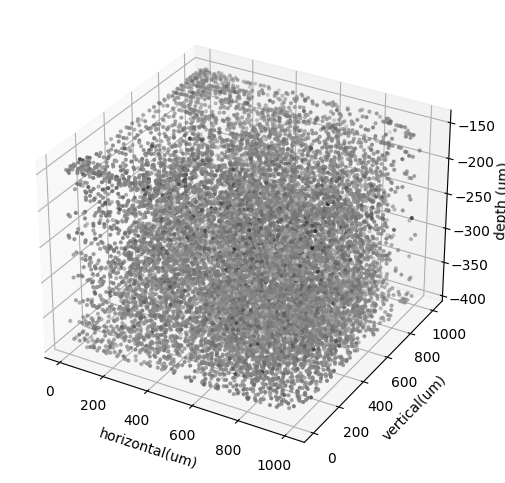

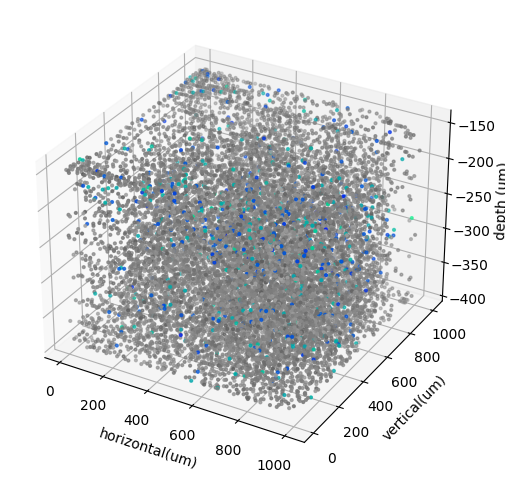

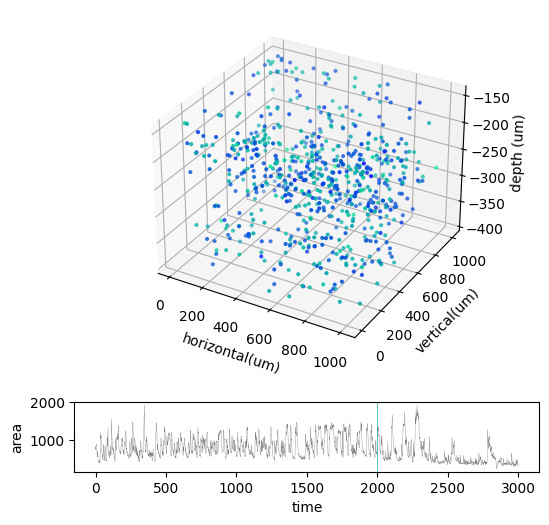

In [26]:

input = tensor_x[0]
input.requires_grad_()
pred = net(input)
pred[:, 2].backward()
heat_map = input.grad
heat_map = zscore(heat_map)

# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

x, y, z = data['neuron_pos']

norm = Normalize(vmin=torch.min(heat_map), vmax=torch.max(heat_map))
heat_gray = cm.binary(norm(heat_map))
heat_color = cm.winter(norm(heat_map))
highlight_colors = [heat_gray[i] if abs(heat_map[i]) < 2 else heat_color[i] for i in range(len(heat_map))]
highlight_only = [[0, 0, 0, 0] if abs(heat_map[i]) < 2 else heat_color[i] for i in range(len(heat_map))]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=heat_gray)
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=highlight_colors)
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

from matplotlib import gridspec
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

# ax = fig.add_subplot(211, projection='3d')
ax = plt.subplot(gs[0], projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=highlight_only)
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')

ax2 = plt.subplot(gs[1])
plt.plot(data['pupil_area'][:3000, 0], linewidth=0.25, c='gray')
ax2.axvline(x=2000, linewidth=0.5, c='lightseagreen')
ax2.set(xlabel='time', ylabel='area')

plt.savefig("images/test.png")
plt.show()


# f.tight_layout()



KeyboardInterrupt: 

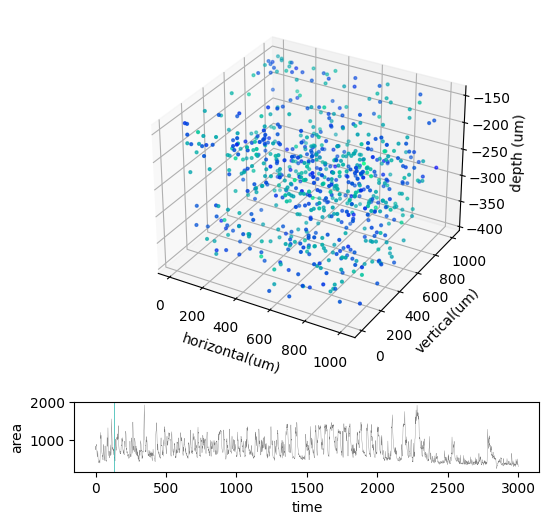

In [27]:
# Make movie of first 3000 datapoints
from matplotlib import gridspec

x, y, z = data['neuron_pos']
target = one_hot_encode(data['pupil_area'], xtiles=4) 

for time_i in range(3000):
    input = tensor_x[0]
    input.requires_grad_()
    pred = net(input)
    pred[:, np.argmax(target[time_i])].backward()
    heat_map = input.grad
    heat_map = zscore(heat_map)

    norm = Normalize(vmin=torch.min(heat_map), vmax=torch.max(heat_map))
    heat_gray = cm.binary(norm(heat_map))
    heat_color = cm.winter(norm(heat_map))
    highlight_colors = [heat_gray[i] if abs(heat_map[i]) < 2 else heat_color[i] for i in range(len(heat_map))]
    highlight_only = [[0, 0, 0, 0] if abs(heat_map[i]) < 2 else heat_color[i] for i in range(len(heat_map))]


    
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

    # ax = fig.add_subplot(211, projection='3d')
    ax = plt.subplot(gs[0], projection='3d')
    ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=highlight_colors)
    ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')

    ax2 = plt.subplot(gs[1])
    plt.plot(data['pupil_area'][:3000, 0], linewidth=0.25, c='gray')
    ax2.axvline(x=time_i, linewidth=0.5, c='lightseagreen')
    ax2.set(xlabel='time', ylabel='area')
    
    plt.savefig(f'images/{time_i}.png')
    plt.close()

